In [76]:
import numpy as np

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [78]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [79]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [80]:
np.random.seed(0)

In [81]:
# Data Preparation

In [82]:
def load_data(file_path):
    tokenizer = Tokenizer(filters="")
    whole_texts = []
    for line in open(file_path, encoding='utf-8'):
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

In [83]:
X_train, tokenizer_en = load_data('/root/userspace/private/RNN/train.en')
Y_train, tokenizer_ja = load_data('/root/userspace/private/RNN/train.ja')

In [84]:
en_vocab_size = len(tokenizer_en.word_index) + 1
jp_vocab_size = len(tokenizer_ja.word_index) + 1

In [85]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train,
                                                                Y_train,
                                                                test_size=0.02,
                                                                random_state=42)

In [86]:
X_train = pad_sequences(X_train, padding='post')
Y_train = pad_sequences(Y_train, padding='post')

In [87]:
# Building a model

In [88]:
class RNNEncoderDecoderAtt(object):
    def __init__(self, dim_input_seq, dim_input_vocab, dim_output_seq, dim_output_vocab, dim_emb, dim_hid, dim_att):
        self.dim_input_seq = dim_input_seq
        self.dim_input_vocab = dim_input_vocab
        
        self.dim_output_seq = dim_output_seq
        self.dim_output_vocab = dim_output_vocab
        
        self.dim_emb = dim_emb
        self.dim_hid = dim_hid
        self.dim_att = dim_att
        
        # Model
        self._model = None
        self._model_validation_encoder = None
        self._model_validation_decoder = None
        self._model_validation_attention = None
        
        # Encoder 
        ## Layer
        self._encoder_inputs = None
        
        ## Tensor
        self._encoded_seq = None
        self._encoder_states = None
        
        # Decoder
        ## Layer
        self._decoder_embedding = None
        self._decoder_lstm = None
        self._decoder_dense = None

        # Attension
        ## Layer
        self._attention_score_dense = None
        self._attention_dense = None
        
        # Output
        ## Layer
        self._output_dense = None
        
    def inference(self):
        from keras.models import Model
        from keras.layers import Input, Embedding, Dense, LSTM, concatenate, dot, Activation

        # Encoder
        ## Input Layer
        self._encoder_inputs = Input(shape=(self.dim_input_seq,))

        ## Embedding Layer
        encoder_embedded = Embedding(self.dim_input_vocab, self.dim_emb, mask_zero=True)(self._encoder_inputs) # (dim_seq_input,)->(dim_seq_input, dim_emb)
        
        ## LSTM Layer
        self._encoded_seq, *(self._encoder_states) = LSTM(self.dim_hid, return_sequences=True, return_state=True)(encoder_embedded)  # (dim_seq_input, dim_emb)->(dim_seq_input, dim_hid)

        # Decoder
        ## Instance
        self._decoder_embedding = Embedding(self.dim_output_vocab, self.dim_emb)
        self._decoder_lstm = LSTM(self.dim_hid, return_sequences=True, return_state=True)
        
        ## Input Layer
        decoder_inputs = Input(shape=(self.dim_output_seq,))

        ## Embedding Layer
        decoder_embedded = self._decoder_embedding(decoder_inputs)  # (dim_seq_output,)->(dim_seq_output, dim_emb)
        
        ## LSTM Layer       
        decoded_seq, _, _ = self._decoder_lstm(decoder_embedded, initial_state=self._encoder_states) # (dim_seq_output, dim_emb)->(dim_seq_output, dim_hid)
        
        # Attention
        ## Instance
        self._attention_score_dense = Dense(self.dim_hid)
        self._attention_dense = Dense(self.dim_att, activation='tanh')
        
        ## Attention
        score = self._attention_score_dense(decoded_seq)        # (dim_seq_output, dim_hid) -> (dim_seq_output, dim_hid)
        score = dot([score, self._encoded_seq], axes=(2,2))           # [(dim_seq_output, dim_hid), (dim_seq_input, dim_hid)] -> (dim_seq_output, dim_seq_input)
        attention = Activation('softmax')(score)                # (dim_seq_output, dim_seq_input) -> (dim_seq_output, dim_seq_input)

        ## Context
        context = dot([attention, self._encoded_seq], axes=(2,1))     # [(dim_seq_output, dim_seq_input), (dim_seq_input, dim_hid)] -> (dim_seq_output, dim_hid)
        concat = concatenate([context, decoded_seq], axis=2)    # [(dim_seq_output, dim_hid), (dim_seq_output, dim_hid)] -> (dim_seq_output, 2*dim_hid)
        attentional = self._attention_dense(concat)             # (dim_seq_output, 2*hid_dim) -> (dim_seq_output, dim_att)
        
        # Output Layer
        ## Instance
        self._output_dense = Dense(self.dim_output_vocab, activation='softmax')
        
        ## Output
        predictions = self._output_dense(attentional)  # (dim_seq_output, dim_att) -> (dim_seq_output, dim_vocab_output)
        
        return Model([self._encoder_inputs, decoder_inputs], predictions)     
 
    def inference_validation(self):
        from keras.models import Model
        from keras.layers import Input, dot, concatenate, Activation
        
        # Encoder
        model_encoder = Model(self._encoder_inputs, [self._encoded_seq]+self._encoder_states)

        # Decoder
        decoder_inputs = Input(shape=(1,))
        decoder_inputs_states = [Input(shape=(self.dim_hid,)), Input(shape=(self.dim_hid,))]
        
        decoder_embeded = self._decoder_embedding(decoder_inputs)
        decoded_seq, *decoder_states = self._decoder_lstm(decoder_embeded, initial_state=decoder_inputs_states)

        model_decoder = Model([decoder_inputs] + decoder_inputs_states, [decoded_seq] + decoder_states)

        # Attention
        encoded_seq_in = Input(shape=(self.dim_input_seq, self.dim_hid))
        decoded_seq_in = Input(shape=(1, self.dim_hid))
        
        ## Score
        score = self._attention_score_dense(decoded_seq_in)
        score = dot([score, encoded_seq_in], axes=(2,2))
        attention = Activation('softmax')(score)
        
        ## Context
        context = dot([attention, encoded_seq_in], axes=(2,1))
        concat = concatenate([context, decoded_seq_in], axis=2)
        attentional = self._attention_dense(concat)
        
        # Output Layer
        predictions = self._output_dense(attentional)

        model_attention = Model([encoded_seq_in, decoded_seq_in], predictions)
        
        return model_encoder, model_decoder, model_attention
               
    def predict(self, X, bos_eos, max_output_length = 1000):
        encoded_seq, *states_value = self._model_validation_encoder.predict(X)

        target_seq = np.array(bos_eos[0])
        output_seq = bos_eos[0][:]

        while True:
            decoded_seq, *states_value = self._model_validation_decoder.predict([target_seq] + states_value)
            output_tokens = self._model_validation_attension.predict([encoded_seq, decoded_seq])
            sampled_token_index = [np.argmax(output_tokens[0, -1, :])]
            output_seq += sampled_token_index

            if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
                break

            target_seq = np.array(sampled_token_index)

        return output_seq

    def compile(self):
        self._model = self.inference()
        self._model.compile(loss='sparse_categorical_crossentropy',
                            optimizer='rmsprop',
                            metrics=['accuracy'])
        
        self._model_validation_encoder, self._model_validation_decoder, self._model_validation_attention = self.inference_validation()
        
    def fit(self, X_train, Y_train, epochs, batch_size, verbose=1):
        train_target = np.hstack((Y_train[:, 1:], np.zeros((len(Y_train),1), dtype=np.int32)))
        
        history = self._model.fit([X_train, Y_train],
                                  np.expand_dims(train_target, -1),
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=verbose,
                                  validation_split=0.2)
        
        return history.history
    
    def show_graph(self):
        return model_to_dot(self._model).create(prog='dot', format='svg')

In [106]:
dim_input_seq = len(X_train[0])
dim_output_seq = len(Y_train[0])

In [89]:
model = RNNEncoderDecoderAtt(dim_input_seq=dim_input_seq,
                             dim_input_vocab=en_vocab_size,
                             dim_output_seq=dim_output_seq,
                             dim_output_vocab=jp_vocab_size,
                             dim_emb=256,
                             dim_hid=256,
                             dim_att=256)

In [90]:
model.compile()

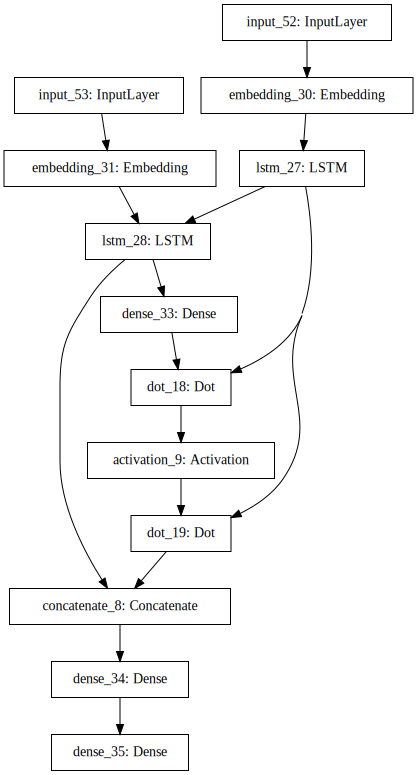

In [91]:
SVG(model.show_graph())

In [92]:
# Training the model

In [93]:
history = model.fit(X_train,
                    Y_train,
                    epochs=10,
                    batch_size=128)

Train on 39200 samples, validate on 9800 samples
Epoch 1/10
39200/39200 [==============================] - 111s 3ms/step - loss: 2.9063 - acc: 0.4860 - val_loss: 2.2865 - val_acc: 0.5814
Epoch 2/10
39200/39200 [==============================] - 107s 3ms/step - loss: 2.0914 - acc: 0.6158 - val_loss: 1.9708 - val_acc: 0.6406
Epoch 3/10
39200/39200 [==============================] - 107s 3ms/step - loss: 1.8245 - acc: 0.6594 - val_loss: 1.7805 - val_acc: 0.6667
Epoch 4/10
39200/39200 [==============================] - 106s 3ms/step - loss: 1.6331 - acc: 0.6878 - val_loss: 1.6299 - val_acc: 0.6894
Epoch 5/10
39200/39200 [==============================] - 106s 3ms/step - loss: 1.4718 - acc: 0.7138 - val_loss: 1.4946 - val_acc: 0.7112
Epoch 6/10
39200/39200 [==============================] - 106s 3ms/step - loss: 1.3364 - acc: 0.7371 - val_loss: 1.4001 - val_acc: 0.7283
Epoch 7/10
39200/39200 [==============================] - 106s 3ms/step - loss: 1.2238 - acc: 0.7569 - val_loss: 1.3227 - v

In [95]:
# Confirming the result

In [96]:
def show_graph(history, key, title=None, xlabel=None, ylabel=None, yscale=None):
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    ax.plot(history[key])

    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    if yscale:
        plt.yscale(yscale)

    plt.show()

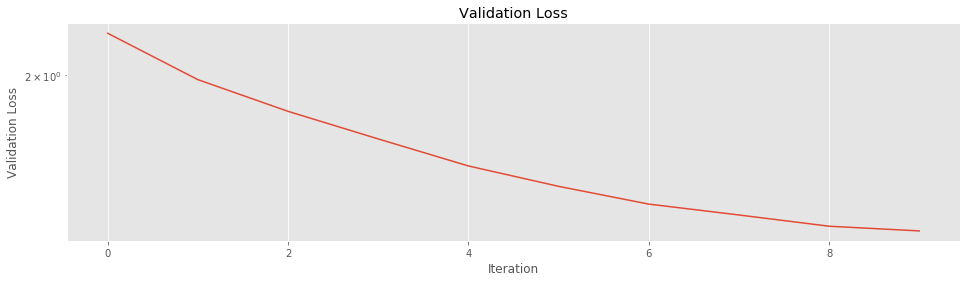

In [97]:
show_graph(history, 'val_loss', 'Validation Loss', 'Iteration', 'Validation Loss', 'log')

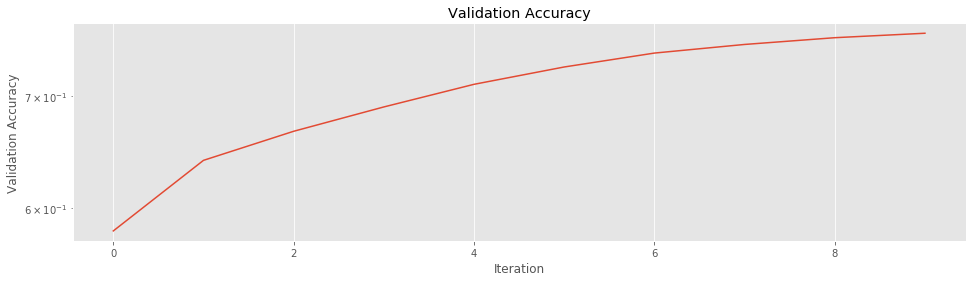

In [98]:
show_graph(history, 'val_acc', 'Validation Accuracy', 'Iteration', 'Validation Accuracy', 'log')

In [99]:
detokenizer_en = dict(map(reversed, tokenizer_en.word_index.items()))
detokenizer_ja = dict(map(reversed, tokenizer_ja.word_index.items()))

In [100]:
bos_eos = tokenizer_ja.texts_to_sequences(["<s>", "</s>"])

In [102]:
def inference_validation(self):
    from keras.models import Model
    from keras.layers import Input, dot, concatenate, Activation

    # Encoder
    model_encoder = Model(self._encoder_inputs, [self._encoded_seq]+self._encoder_states)

    # Decoder
    decoder_inputs = Input(shape=(1,))
    decoder_inputs_states = [Input(shape=(self.dim_hid,)), Input(shape=(self.dim_hid,))]

    decoder_embeded = self._decoder_embedding(decoder_inputs)
    decoded_seq, *decoder_states = self._decoder_lstm(decoder_embeded, initial_state=decoder_inputs_states)

    model_decoder = Model([decoder_inputs] + decoder_inputs_states, [decoded_seq] + decoder_states)

    # Attention
    encoded_seq_in = Input(shape=(self.dim_input_seq, self.dim_hid))
    decoded_seq_in = Input(shape=(1, self.dim_hid))

    ## Score
    score = self._attention_score_dense(decoded_seq_in)
    score = dot([score, encoded_seq_in], axes=(2,2))
    attention = Activation('softmax')(score)

    ## Context
    context = dot([attention, encoded_seq_in], axes=(2,1))
    concat = concatenate([context, decoded_seq_in], axis=2)
    attentional = self._attention_dense(concat)

    # Output Layer
    predictions = self._output_dense(attentional)

    model_attention = Model([encoded_seq_in, decoded_seq_in], predictions)

    return model_encoder, model_decoder, model_attention

In [103]:
model._model_validation_encoder, model._model_validation_decoder, model._model_validation_attention = inference_validation(model)

In [108]:
def predict(self, X, bos_eos, max_output_length = 1000):
    encoded_seq, *states_value = self._model_validation_encoder.predict(X)

    target_seq = np.array(bos_eos[0])
    output_seq = bos_eos[0][:]

    while True:
        decoded_seq, *states_value = self._model_validation_decoder.predict([target_seq] + states_value)
        output_tokens = self._model_validation_attention.predict([encoded_seq, decoded_seq])
        sampled_token_index = [np.argmax(output_tokens[0, -1, :])]
        output_seq += sampled_token_index

        if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
            break

        target_seq = np.array(sampled_token_index)

    return output_seq

In [105]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu(refs, preds):
    return np.mean([sentence_bleu(r, p, emulate_multibleu=True) for r, p in zip(refs, preds)])

In [116]:
for text_no in range(len(X_validation)):
    inp = [detokenizer_en[i] for i in X_validation[text_no][1:-1]]
    ref = [detokenizer_ja[i] for i in Y_validation[text_no][1:-1]]
    
    input_seq = pad_sequences([X_validation[text_no]], dim_input_seq, padding='post')
    pred = [detokenizer_ja[i] for i in predict(model, input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.0:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['you', 'may', 'extend', 'your', 'stay', 'in', 'tokyo', '.']
正解文: ['東京', '滞在', 'を', '延ば', 'し', 'て', 'も', 'い', 'い', 'で', 'す', 'よ', '。']
生成文: ['東京', 'で', 'は', 'お', '客', 'で', 'す', '。']
bleu: 0.7825422900366437

text_no: 1
元の文: ['i', 'study', 'at', 'school', '.']
正解文: ['私', 'は', '学校', 'で', '勉強', 'する', '。']
生成文: ['私', 'は', '学校', 'で', '勉強', 'し', 'ま', 'す', '。']
bleu: 0.8633400213704505

text_no: 2
元の文: ['i', 'always', 'brush', 'my', 'coat', 'when', 'i', 'come', 'home', '.']
正解文: ['私', 'は', '帰宅', 'する', 'と', 'いつ', 'も', 'コート', 'に', 'ブラシ', 'を', 'かけ', 'る', '。']
生成文: ['私', 'は', 'いつ', 'も', '帰宅', 'する', '時', 'に', 'コート', 'を', '書', 'い', 'た', '。']
bleu: 0.8408964152537145

text_no: 3
元の文: ['your', 'mother', 'has', 'made', 'you', 'what', 'you', 'are', '.']
正解文: ['君', 'が', '今日', 'あ', 'る', 'の', 'は', 'お', '母', 'さん', 'の', 'おかげ', 'だ', '。']
生成文: ['あなた', 'の', 'お', '母', 'さん', 'は', 'あなた', 'の', 'おかげ', 'で', 'あ', 'る', 'よう', 'に', 'し', 'た', '。']
bleu: 0.8010548969451144

text_no: 4
元の文: ['don', "'t", 's

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 499
元の文: ['he', 'made', 'me', 'out', 'to', 'be', 'a', 'liar', '.']
正解文: ['彼', 'は', '私', 'が', 'うそつき', 'で', 'あ', 'る', 'か', 'の', 'よう', 'に', '言', 'っ', 'た', '。']
生成文: ['彼', 'は', '私', 'に', 'な', 'ら', 'ず', 'に', '見え', 'た', '。']
bleu: 0.8593887047640296

text_no: 500
元の文: ['i', 'just', 'don', "'t", 'know', 'what', 'to', 'say', '.']
正解文: ['何', 'と', 'も', '言', 'い', 'よう', 'が', 'な', 'い', 'なあ', '。']
生成文: ['何', 'を', '言', 'っ', 'て', 'い', 'る', 'の', 'か', 'わか', 'ら', 'な', 'い', '。']
bleu: 0.7730551756939454

text_no: 501
元の文: ['i', 'used', 'to', 'go', 'to', 'school', 'with', 'ken', '.']
正解文: ['私', 'は', 'よく', '健', 'と', '一緒', 'に', '学校', 'へ', '行', 'っ', 'た', 'もの', 'で', 'す', '。']
生成文: ['私', 'は', 'ケン', 'と', '学校', 'に', '行', 'っ', 'た', '。']
bleu: 0.9457416090031758

text_no: 502
元の文: ['the', 'secret', 'got', 'out', '.']
正解文: ['秘密', 'が', '漏れ', 'た', '。']
生成文: ['その', '秘密', 'は', '出', 'て', 'き', 'た', '。']
bleu: 0.7071067811865476

text_no: 503
元の文: ['the', 'girl', 'played', 'the', 'baby', 'to', 'her', 'mother', '.'

In [115]:
for text_no in range(len(X_validation)):
    inp = [detokenizer_en[i] for i in X_validation[text_no][1:-1]]
    ref = [detokenizer_ja[i] for i in Y_validation[text_no][1:-1]]
    
    input_seq = pad_sequences([X_validation[text_no]], dim_input_seq, padding='post')
    pred = [detokenizer_ja[i] for i in predict(model, input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.95:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 20
元の文: ['he', 'is', 'almost', 'always', 'at', 'home', '.']
正解文: ['彼', 'は', 'ほとんど', 'いつ', 'も', '家', 'に', 'い', 'る', '。']
生成文: ['彼', 'は', 'いつ', 'も', '家', 'に', 'い', 'る', '。']
bleu: 0.9709835434146469

text_no: 62
元の文: ['have', 'you', 'taken', 'your', 'medicine', 'yet', '?']
正解文: ['君', 'は', 'もう', '薬', 'を', '飲', 'み', 'ま', 'し', 'た', 'か', '。']
生成文: ['あなた', 'は', 'もう', '薬', 'を', '飲', 'み', 'ま', 'し', 'た', 'か', '。']
bleu: 0.9554427922043668

text_no: 105
元の文: ['his', 'car', 'fell', 'into', 'the', 'lake', '.']
正解文: ['彼', 'の', '車', 'は', '湖', 'の', '中', 'に', '落ち', 'た', '。']
生成文: ['彼', 'の', '車', 'は', '湖', 'に', '落ち', 'た', '。']
bleu: 0.9709835434146469

text_no: 154
元の文: ['be', 'sure', 'to', 'put', 'out', 'the', 'fire', 'before', 'you', 'leave', '.']
正解文: ['あなた', 'は', '離れ', 'る', '前', 'に', '必ず', '火', 'を', '消', 'し', 'なさ', 'い', '。']
生成文: ['出かけ', 'る', '前', 'に', '火', 'を', '消', 'し', 'なさ', 'い', '。']
bleu: 0.9510699415570292

text_no: 168
元の文: ['he', 'heard', 'the', 'dog', 'barking', '.']
正解文: ['彼', 'は'

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 529
元の文: ['they', 'used', 'to', 'live', 'next', 'door', 'to', 'us', '.']
正解文: ['彼', 'ら', 'は', '以前', '私', 'たち', 'の', '隣', 'に', '住', 'ん', 'で', 'い', 'た', '。']
生成文: ['彼', 'ら', 'は', '我々', 'の', '隣', 'に', '住', 'ん', 'で', 'い', 'た', '。']
bleu: 0.9801882078613897

text_no: 541
元の文: ['it', "'s", 'rainy', 'today', '.']
正解文: ['今日', 'は', '雨降り', 'で', 'す', '。']
生成文: ['今日', 'は', '雨', 'で', 'す', '。']
bleu: 0.9554427922043668

text_no: 542
元の文: ['i', 'want', 'to', 'drive', '.']
正解文: ['私', 'は', '車', 'を', '運転', 'し', 'た', 'い', '。']
生成文: ['私', 'は', '車', 'を', '運転', 'し', 'た', 'い', '。']
bleu: 0.9709835434146469

text_no: 544
元の文: ['she', 'wanted', 'me', 'to', 'come', '.']
正解文: ['彼女', 'は', '私', 'に', '来', 'て', 'もら', 'い', 'たが', 'っ', 'て', 'い', 'た', '。']
生成文: ['彼女', 'は', '私', 'に', '来', 'た', '。']
bleu: 0.9621954581957615

text_no: 558
元の文: ['why', 'is', 'it', 'so', 'hot', '?']
正解文: ['どう', 'し', 'て', '、', 'こんな', 'に', '暑', 'い', 'の', 'で', 'す', 'か', '。']
生成文: ['なぜ', '暑', 'い', 'の', 'で', 'す', 'か', '。']
bleu: 0.967168